In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Preprocess Data
In the <b>HW3_template</b> folder you will find `TSLA.csv`, `GOOGL.csv` and `DJI.csv` files. Use Pandas (You have used it in HW1) to retrieve the dataset. Use only <b>Open</b> price as your input. (You will train three models for three different stocks, don't mix these data together!)

In [6]:
g_data = pd.read_csv('GOOGL.csv')
t_data = pd.read_csv('TSLA.csv')
d_data = pd.read_csv('DJI.csv')

g_price = g_data["Open"].values.reshape((-1,1))
t_price = t_data["Open"].values.reshape((-1,1))
d_price = d_data["Open"].values.reshape((-1,1))

print(g_price.shape)

(3702, 1)


## Normalize your data
You could use `MinMaxScaler` in `sklearn.preprocessing` to normalize the data between 0 and 1.

In [7]:
scaler = MinMaxScaler()
scaler.fit(g_price)
g_norm = scaler.transform(g_price)

scaler = MinMaxScaler()
scaler.fit(t_price)
t_norm = scaler.transform(t_price)

scaler = MinMaxScaler()
scaler.fit(d_price)
d_norm = scaler.transform(d_price)

# Split training, validation and testing data
<p style="font-size:20px">Since you will impelement a many-to-one Recurrent Neural Network model, every input data will have shape [batch_size, num_seq, input_size] and output data will have shape [batch_size, input_size] 

In [10]:
g_tr, g_val, g_test = g_norm[:int(0.8*len(g_norm))], g_norm[int(0.8*len(g_norm)):int(0.9*len(g_norm))], g_norm[int(0.9*len(g_norm)):]
t_tr, t_val, t_test = t_norm[:int(0.8*len(t_norm))], t_norm[int(0.8*len(t_norm)):int(0.9*len(t_norm))], t_norm[int(0.9*len(t_norm)):]
d_tr, d_val, d_test = d_norm[:int(0.8*len(d_norm))], d_norm[int(0.8*len(d_norm)):int(0.9*len(d_norm))], d_norm[int(0.9*len(d_norm)):]

# TesnorFlow Model

In [280]:
Tmax = 100
inp_size = 1

#Google Model:
#rnn_units1 = 200
#lr = 0.001

#Tesla Model:
#rnn_units1 = 100
#lr = 0.0005

rnn_units1 = 30
lr = 0.0003

tf.reset_default_graph()
with tf.name_scope("data"):
    X = tf.placeholder(dtype=tf.float32, shape=[None, Tmax, inp_size])
    y = tf.placeholder(dtype=tf.float32, shape=[None, 1])
    batch_size = tf.placeholder(tf.int32, [], name='batch_size')

def RNN(X):
    cell = tf.nn.rnn_cell.LSTMCell(rnn_units1)
    initial_state = cell.zero_state(batch_size, dtype=tf.float32)
    output, state = tf.nn.dynamic_rnn(cell, X, initial_state=initial_state, dtype=tf.float32)
    rnn_out = output[:,-1,:]
    out = tf.layers.dense(rnn_out, 1, activation=tf.nn.relu, use_bias=True)
    return out

out = RNN(X)
loss = tf.reduce_mean(tf.square(out - y))
optimizer = tf.train.AdamOptimizer(lr)
train_op = optimizer.minimize(loss)
init = tf.initializers.global_variables()

In [281]:
def get_batch(data, i, num_steps, batch_size):
    num_of_batches = len(data) // batch_size # ......******------++++++^^^^^^ <- batch_size = 5, num_of_batches = 6, step_size = 2
    num_iters = (num_of_batches - 1) // num_steps 
    X_batch = np.zeros((batch_size, num_steps)) 
    y_batch = np.zeros((batch_size,1))       
    for j in range(batch_size): 
        batch = data[j * num_of_batches: (j + 1) * num_of_batches,:]
        X_batch[j,:] = batch[i * num_steps: (i + 1) * num_steps,:].T
        y_batch[j] = batch[(i + 1) * num_steps][0]
    X_batch = np.expand_dims(X_batch, axis=2)
    y_batch.reshape((batch_size, 1))
    return X_batch, y_batch
'''
x, y = get_batch(g_val, 1, 119, 2)
print(x.shape, y.shape)
print(len(g_val))
'''

'\nx, y = get_batch(g_val, 1, 119, 2)\nprint(x.shape, y.shape)\nprint(len(g_val))\n'

# Training

In [282]:
epoch = 20
tr_batch_size = 2
val_batch_size = 1
def num_iter(length, batch_size):
    num_of_batches = length // batch_size
    #print(Tmax, num_of_batches, batch_size)
    num_iters = (num_of_batches - 1) // Tmax
    return num_iters
num_iters = num_iter(len(t_tr), tr_batch_size)
val_iters = num_iter(len(t_val), val_batch_size)
#print(val_iters)
tr_loss_li = []
val_loss_li = []
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    for i in range(epoch):
        for j in range(num_iters):
            X_batchs, y_batchs = get_batch(d_tr, j, Tmax, tr_batch_size)
            #print(X_batchs.shape, y_batchs.shape)
            sess.run(train_op, feed_dict={X:X_batchs, y:y_batchs, batch_size:tr_batch_size})
            if (j == num_iters - 1):
                tr_loss = sess.run(loss, feed_dict={X:X_batchs, y:y_batchs, batch_size:tr_batch_size})
                tr_loss_li.append(tr_loss)
                print("The training loss at "+str(i+1)+"th epoch is: {:.3f}".format(tr_loss))
        val_loss = 0
        count = 0
        for k in range(val_iters):
            X_batch, y_batch = get_batch(d_val, k, Tmax, val_batch_size)
            #print(X_batch.shape, y_batch.shape)
            val_loss += sess.run(loss, feed_dict={X:X_batch, y:y_batch, batch_size:val_batch_size})
            count += 1
        print("The validation loss at "+str(i+1)+"th epoch is: {:.3f}".format(val_loss / count))
        save_path = saver.save(sess, 'model.ckpt')
    

The training loss at 1th epoch is: 0.017
The validation loss at 1th epoch is: 0.076
The training loss at 2th epoch is: 0.009
The validation loss at 2th epoch is: 0.044
The training loss at 3th epoch is: 0.004
The validation loss at 3th epoch is: 0.020
The training loss at 4th epoch is: 0.003
The validation loss at 4th epoch is: 0.006
The training loss at 5th epoch is: 0.003
The validation loss at 5th epoch is: 0.001
The training loss at 6th epoch is: 0.002
The validation loss at 6th epoch is: 0.001
The training loss at 7th epoch is: 0.001
The validation loss at 7th epoch is: 0.001
The training loss at 8th epoch is: 0.001
The validation loss at 8th epoch is: 0.002
The training loss at 9th epoch is: 0.001
The validation loss at 9th epoch is: 0.001
The training loss at 10th epoch is: 0.000
The validation loss at 10th epoch is: 0.000
The training loss at 11th epoch is: 0.000
The validation loss at 11th epoch is: 0.000
The training loss at 12th epoch is: 0.000
The validation loss at 12th ep

# Testing

In [284]:
test_iters = 100
test_batch_size = 1
test_result = []
ground_truth = []
with tf.Session() as sess:
    saver.restore(sess, "model.ckpt")
    for k in range(test_iters):
        X_batch, y_batch = np.expand_dims(d_test[k:k+100,:].T, axis=2), d_test[k+100:,]
        ground_truth.append(y_batch[0][0])
        val_loss += sess.run(loss, feed_dict={X:X_batch, y:y_batch, batch_size:test_batch_size})
        pred = sess.run(out, feed_dict={X:X_batch, batch_size:test_batch_size})
        test_result.append(np.squeeze(pred))
        count += 1
    print("The test loss is: {:.3f}".format(val_loss / count))

INFO:tensorflow:Restoring parameters from model.ckpt
The test loss is: 0.042


Text(0.5, 1.0, "Prediction on Google's stock price within 100 days")

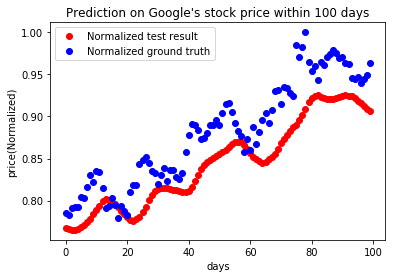

In [140]:
fig = plt.figure()
plt.plot(range(100), test_result, 'ro', label='Normalized test result')
plt.plot(range(100), ground_truth, 'bo', label='Normalized ground truth')
plt.legend(loc=0)
plt.xlabel('days')
plt.ylabel('price(Normalized)')
plt.title('Prediction on Google\'s stock price within 100 days')

Text(0.5, 1.0, "Prediction on Tesla's stock price within 100 days")

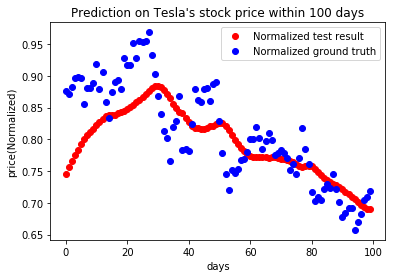

In [190]:
fig = plt.figure()
plt.plot(range(100), test_result, 'ro', label='Normalized test result')
plt.plot(range(100), ground_truth, 'bo', label='Normalized ground truth')
plt.legend(loc=0)
plt.xlabel('days')
plt.ylabel('price(Normalized)')
plt.title('Prediction on Tesla\'s stock price within 100 days')

Text(0.5, 1.0, "Prediction on Dow Jones Industrial Average Index's stock price within 100 days")

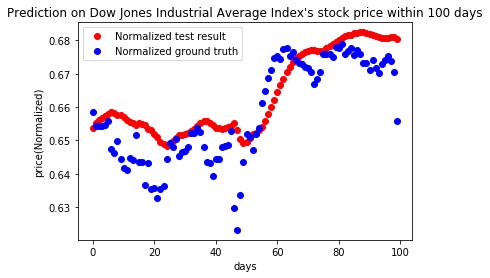

In [286]:
fig = plt.figure()
plt.plot(range(100), test_result, 'ro', label='Normalized test result')
plt.plot(range(100), ground_truth, 'bo', label='Normalized ground truth')
plt.legend(loc=0)
plt.xlabel('days')
plt.ylabel('price(Normalized)')
plt.title('Prediction on Dow Jones Industrial Average Index\'s stock price within 100 days')